In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from statistics import mean
from datetime import timedelta



In [30]:
def fullDay(data):
        
    dates = list()
    data = data.reset_index(drop=True)
    for i in range(0,len(data.index)):
        dates.append(data['Display Time'][i].date())
    data['Dates'] = dates
    end = data['Dates'].iloc[-1]
    start = data['Dates'].iloc[0]

    indexVals = data[ data['Dates'] == start ].index
    # indexVals
    data.drop(indexVals , inplace=True)

    indexVals = data[ data['Dates'] == end ].index
    # indexVals
    data.drop(indexVals , inplace=True)

    data = data.reset_index(drop=True)

    data.drop(['Dates'], axis=1, inplace=True)

    return data

In [31]:
def subSample(data):
        """
            Sampling a time-series at 15 minute intervals
            Input:
                data: time-series with irregular intervals
            Output:
                data: time-series with 15 minute intervals
        """ 
        data = data.reset_index(drop=True)
        data['Display Time'] = pd.to_datetime(data['Display Time'])
        data['time_gap'] = data['Display Time'].shift(1)-data['Display Time'][0]
        data['time_gap'][0] = '00:00:00'
        mods = [0,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899]
        subset = pd.DataFrame()
        for i in range(1,len(data.index)):
            seconds = data['time_gap'][i].total_seconds()
            if (seconds%900) in mods:
                subj_id = data['subjectId'][i]
                gv = data['GlucoseValue'][i]
                dt = data['Display Time'][i]
                temp_df = pd.DataFrame({'Display Time':[dt], 'GlucoseValue':[gv], 'subjectId':[subj_id]})
                subset = pd.concat([temp_df,subset],ignore_index=True)
        subset = subset.iloc[::-1]
        subset = subset.reset_index(drop=True)
        data.drop(['time_gap'], axis=1, inplace=True)
        data = data.reset_index(drop=True)
        return subset

In [123]:
def variabilityEpisodes(df, unit):
    time_diff = timedelta(hours=0, minutes=15, seconds=30)
    
    
    
    if unit == 'mg':
        hypoglycemia = df[df.GlucoseValue<=54]
        hyperglycemia = df[df.GlucoseValue>=250]
    elif unit == 'mmol':
        hypoglycemia = df[df.GlucoseValue<=3]
        hyperglycemia = df[df.GlucoseValue>=13.9]
    else:
        print("Unit should be 'mg' or 'mmol'")
        return 0,0
     
    hypoglycemia = hypoglycemia.reset_index(drop=True)
    hypoglycemia['Display Time'] = pd.to_datetime(hypoglycemia['Display Time'])
    hypoglycemia['time_gap'] = hypoglycemia['Display Time'].diff()
    hypoglycemic_episodes = 0
    
    for gap in hypoglycemia['time_gap']:
        if gap <= time_diff:
            hypoglycemic_episodes+=1

    
    
    hyperglycemia = hyperglycemia.reset_index(drop=True)
    hyperglycemia['Display Time'] = pd.to_datetime(hyperglycemia['Display Time'])
    hyperglycemia['time_gap'] = hyperglycemia['Display Time'].diff()
    
    hyperglycemia_episodes = 0
    for gap in hyperglycemia['time_gap']:
        if gap <= time_diff:
            hyperglycemia_episodes+=1
            
    return hypoglycemic_episodes, hyperglycemia_episodes

In [124]:
data = pd.read_csv("~/Desktop/NCSA_genomics/Python - notebooks/TSForecasting/Data/consolidatedDataForPackage.csv")

data['Display Time'] = pd.to_datetime(data['Display Time'])
data['GlucoseValue'] = pd.to_numeric(data['GlucoseValue'])
xx = data[data['subjectId'] == "GVP01"]
xx.dtypes

Display Time    datetime64[ns]
GlucoseValue           float64
subjectId               object
dtype: object

In [125]:
xx = fullDay(xx)
xx = subSample(xx)
xx

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Display Time,GlucoseValue,subjectId
0,2016-06-22 00:15:00,128.0,GVP01
1,2016-06-22 00:30:00,126.0,GVP01
2,2016-06-22 00:45:00,125.0,GVP01
3,2016-06-22 01:00:00,125.0,GVP01
4,2016-06-22 01:15:00,124.0,GVP01
...,...,...,...
378,2016-06-25 22:45:00,128.0,GVP01
379,2016-06-25 23:00:00,137.0,GVP01
380,2016-06-25 23:15:00,166.0,GVP01
381,2016-06-25 23:30:00,206.0,GVP01


[Text(0, 0, '2016-06-22 00:15:00'),
 Text(0, 0, '2016-06-22 00:30:00'),
 Text(0, 0, '2016-06-22 00:45:00'),
 Text(0, 0, '2016-06-22 01:00:00'),
 Text(0, 0, '2016-06-22 01:15:00'),
 Text(0, 0, '2016-06-22 01:30:00'),
 Text(0, 0, '2016-06-22 01:45:00'),
 Text(0, 0, '2016-06-22 02:00:00'),
 Text(0, 0, '2016-06-22 02:15:00')]

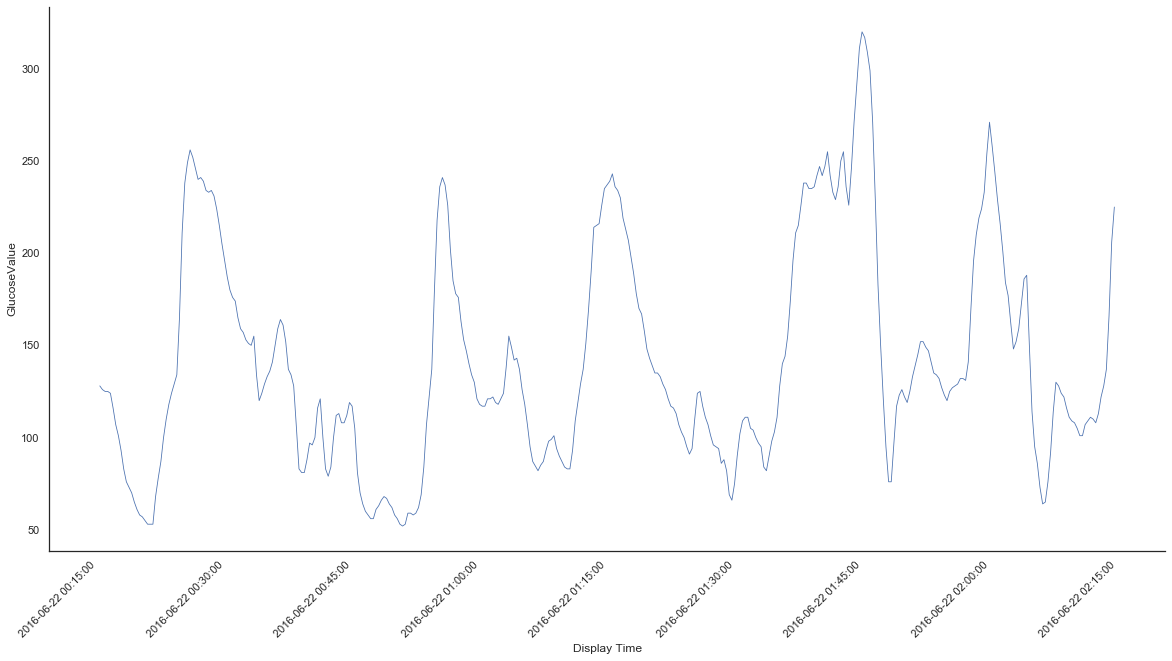

In [126]:
plt.figure(figsize=(20,10))
sns.set(style="white")
fig = sns.lineplot(x = xx.iloc[:, 0], y = xx.iloc[:, 1],
             data=xx, palette="tab10", linewidth=0.8)
sns.despine()
fig.set_xticklabels(labels=xx.iloc[:, 0], rotation=45, ha='right')

In [130]:
hypo, hyper = variabilityEpisodes(xx, "mg")

In [131]:
hypo, hyper

(4, 11)

In [134]:
print("Hypoglycemic episodes: "+str(hypo))

Hypoglycemic episodes: 4


In [135]:
print("Hyperglycemic episodes: "+str(hyper))

Hyperglycemic episodes: 11
